# Named Entity Recognition using BERT


## Setup


In [ ]:
!pip3 install datasets -q
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py

--2021-10-19 21:26:25--  https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7502 (7.3K) [text/plain]
Saving to: ‘conlleval.py.1’

conlleval.py.1      100%[===================>]   7.33K  --.-KB/s    in 0.001s  

2021-10-19 21:26:25 (8.13 MB/s) - ‘conlleval.py.1’ saved [7502/7502]



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from collections import Counter
from conlleval import evaluate

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings


## Build the NER model class as a `keras.Model` subclass

In [ ]:

class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=128, embed_dim=32, num_heads=2, ff_dim=32
    ):
        super(NERModel, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x


## Load the CoNLL 2003 dataset from the datasets library and process it

In [ ]:
conll_data = load_dataset("conll2003")

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_tags"]
            tokens = record["tokens"]
            f.write(
                str(len(tokens))
                + "\t"
                + "\t".join(tokens)
                + "\t"
                + "\t".join(map(str, ner_tags))
                + "\n"
            )


os.mkdir("data")
export_to_file("./data/conll_train.txt", conll_data["train"])
export_to_file("./data/conll_val.txt", conll_data["validation"])

## Make the NER label lookup table


In [ ]:

def make_tag_lookup_table():
    iob_labels = ["B", "I"]
    ner_labels = ["PER", "ORG", "LOC", "MISC"]
    all_labels = [(label1, label2) for label2 in ner_labels for label1 in iob_labels]
    all_labels = ["-".join([a, b]) for a, b in all_labels]
    all_labels = ["[PAD]", "O"] + all_labels
    return dict(zip(range(0, len(all_labels) + 1), all_labels))


mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'O', 2: 'B-PER', 3: 'I-PER', 4: 'B-ORG', 5: 'I-ORG', 6: 'B-LOC', 7: 'I-LOC', 8: 'B-MISC', 9: 'I-MISC'}


In [ ]:
all_tokens = sum(conll_data["train"]["tokens"], [])
all_tokens_array = np.array(list(map(str.lower, all_tokens)))

counter = Counter(all_tokens_array)
print(len(counter))

num_tags = len(mapping)
vocab_size = 20000

# We only take (vocab_size - 2) most commons words from the training data since
# the `StringLookup` class uses 2 additional tokens - one denoting an unknown
# token and another one denoting a masking token
vocabulary = [token for token, count in counter.most_common(vocab_size - 2)]

# The StringLook class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(
    vocabulary=vocabulary
)

21009


In [ ]:
train_data = tf.data.TextLineDataset("./data/conll_train.txt")
val_data = tf.data.TextLineDataset("./data/conll_val.txt")

In [ ]:
print(list(train_data.take(1).as_numpy_iterator()))

[b'9\tEU\trejects\tGerman\tcall\tto\tboycott\tBritish\tlamb\t.\t3\t0\t7\t0\t0\t0\t7\t0\t0']


In [ ]:

def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    tags += 1
    return tokens, tags


def lowercase_and_convert_to_ids(tokens):
    tokens = tf.strings.lower(tokens)
    return lookup_layer(tokens)


# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 32
train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lowercase_and_convert_to_ids(x), y))
    .padded_batch(batch_size)
)

ner_model = NERModel(num_tags, vocab_size, embed_dim=32, num_heads=4, ff_dim=64)

In [ ]:

class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, name="custom_ner_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=keras.losses.Reduction.NONE
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)


loss = CustomNonPaddingTokenLoss()

## Compile and fit the model

In [ ]:
ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)


def tokenize_and_convert_to_ids(text):
    tokens = text.split()
    return lowercase_and_convert_to_ids(tokens)


# Sample inference using the trained model
sample_input = tokenize_and_convert_to_ids(
    "eu rejects german call to boycott british lamb"
)
sample_input = tf.reshape(sample_input, shape=[1, -1])
print(sample_input)

output = ner_model.predict(sample_input)
prediction = np.argmax(output, axis=-1)[0]
prediction = [mapping[i] for i in prediction]

# eu -> B-ORG, german -> B-MISC, british -> B-MISC
print(prediction)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


439/439 [==============================] - 13s 18ms/step - loss: 0.6306
Epoch 2/10
439/439 [==============================] - 8s 18ms/step - loss: 0.2621
Epoch 3/10
439/439 [==============================] - 8s 18ms/step - loss: 0.1609
Epoch 4/10
439/439 [==============================] - 8s 18ms/step - loss: 0.1248
Epoch 5/10
439/439 [==============================] - 8s 18ms/step - loss: 0.1012
Epoch 6/10
439/439 [==============================] - 8s 18ms/step - loss: 0.0836
Epoch 7/10
439/439 [==============================] - 8s 18ms/step - loss: 0.0687
Epoch 8/10
439/439 [==============================] - 8s 18ms/step - loss: 0.0617
Epoch 9/10
439/439 [==============================] - 8s 18ms/step - loss: 0.0527
Epoch 10/10
439/439 [==============================] - 8s 18ms/step - loss: 0.0444
tf.Tensor([[  988 10950   204   628     6  3938   215  5773]], shape=(1, 8), dtype=int64)
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O']


## Metrics calculation



In [ ]:

def calculate_metrics(dataset):
    all_true_tag_ids, all_predicted_tag_ids = [], []

    for x, y in dataset:
        output = ner_model.predict(x)
        predictions = np.argmax(output, axis=-1)
        predictions = np.reshape(predictions, [-1])

        true_tag_ids = np.reshape(y, [-1])

        mask = (true_tag_ids > 0) & (predictions > 0)
        true_tag_ids = true_tag_ids[mask]
        predicted_tag_ids = predictions[mask]

        all_true_tag_ids.append(true_tag_ids)
        all_predicted_tag_ids.append(predicted_tag_ids)

    all_true_tag_ids = np.concatenate(all_true_tag_ids)
    all_predicted_tag_ids = np.concatenate(all_predicted_tag_ids)

    predicted_tags = [mapping[tag] for tag in all_predicted_tag_ids]
    real_tags = [mapping[tag] for tag in all_true_tag_ids]

    evaluate(real_tags, predicted_tags)


calculate_metrics(val_dataset)

processed 51362 tokens with 5942 phrases; found: 5339 phrases; correct: 3919.
accuracy:  63.26%; (non-O)
accuracy:  93.49%; precision:  73.40%; recall:  65.95%; FB1:  69.48
              LOC: precision:  81.27%; recall:  81.98%; FB1:  81.63  1853
             MISC: precision:  75.97%; recall:  63.77%; FB1:  69.34  774
              ORG: precision:  70.88%; recall:  59.73%; FB1:  64.83  1130
              PER: precision:  64.73%; recall:  55.59%; FB1:  59.81  1582


In [ ]:
 def predict(text): 
  # Sample inference using the trained model
  sample_input = tokenize_and_convert_to_ids(text)
  sample_input = tf.reshape(sample_input, shape=[1, -1])
  print(sample_input)

  output = ner_model.predict(sample_input)
  prediction = np.argmax(output, axis=-1)[0]
  return [mapping[i] for i in prediction]


In [ ]:
!pip install gradio -q

In [ ]:
import gradio as gr

In [ ]:
io = gr.Interface(fn=predict, inputs="text", outputs=["text"])
io.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://16703.gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://16703.gradio.app')

## Output

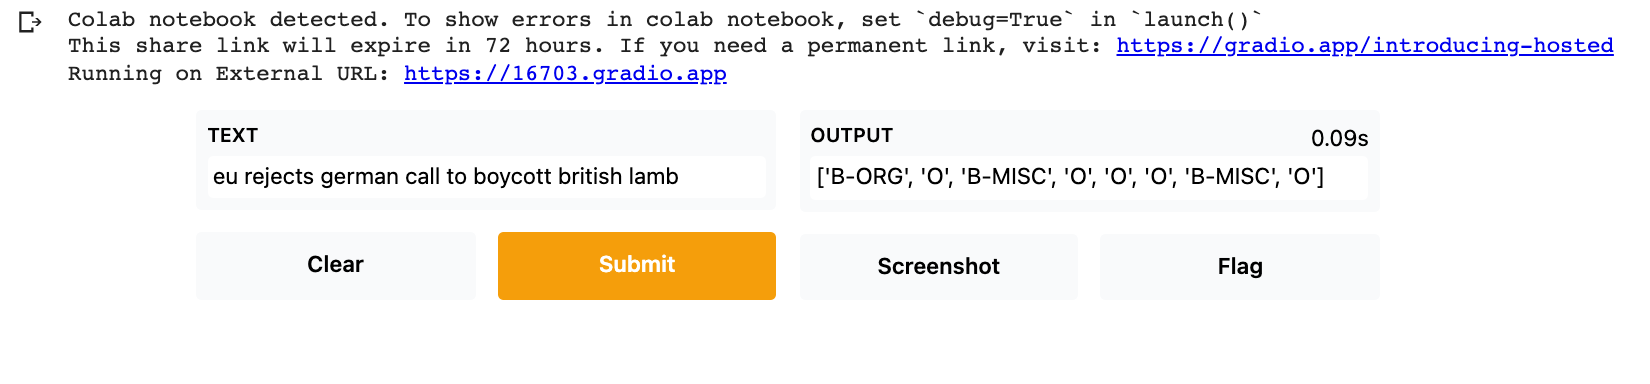